# Challenge 3 : Data Science

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
import warnings
warnings.filterwarnings("ignore")
import os  
%matplotlib inline

## 1. 資料觀察及特徵工程

#### 分別觀察訓練資料及測試資料可以明顯的發現，在訓練資料中，同一群組下資料間的紀錄溫度種類或數量對不起來，
#### 測試資料的溫度也無法與訓練資料做連結，
#### 因此我的想法為平均資料中每種溫度，並計算它的描述性統計量，代表該資料的特徵。
#### 特徵 : ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']

In [2]:
Type = dict(zip(['G11', 'G15', 'G17', 'G19', 'G32', 'G34', 'G48', 'G49'], range(0,8)))

pred_2_type = dict(zip(range(0,8), ['G11', 'G15', 'G17', 'G19', 'G32', 'G34', 'G48', 'G49']))

train_data = pd.DataFrame(columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'target'])

j = 1

for target in ['G11', 'G15', 'G17', 'G19', 'G32', 'G34', 'G48', 'G49'] :
     
    file_dir = './03_Dstrain/' + target
    
    all_files = os.listdir(file_dir)
    
    for file in all_files :

        df = pd.read_csv(file_dir + '/' + file, sep=" \t")
        
        df = df.loc[1:]
        
        df = df.apply(lambda x: x.apply(lambda y : float(y)))
        
        train_data.loc[j] = list(df.mean(axis = 1).describe()) + [Type[target]]
        
        j += 1
        

In [3]:
test_data = pd.DataFrame(columns = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])

file_dir = './03_Dsexam/'

all_files = os.listdir(file_dir)

for file in all_files :

    df = pd.read_csv(file_dir + '/' + file, sep=" \t")
    
    df.reset_index(inplace = True)
    
    df = df.loc[1:]
    
    df = df.apply(lambda x: x.apply(lambda y : float(y)))
    
    if df.iloc[0, 0] == 1 :
        
        df.drop(['index'], axis = 1, inplace = True)

    test_data.loc[int(file.replace('.txt', ''))-1] = list(df.mean(axis = 1).describe())

test_data = test_data.sort_index()

#### 可以發現除了 'min' 之外，其餘特徵在 8 種群組的分布都有明顯的區別

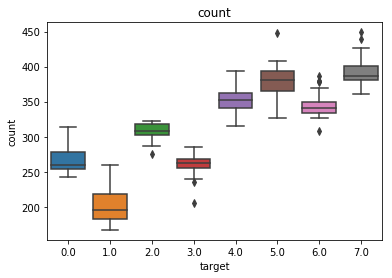

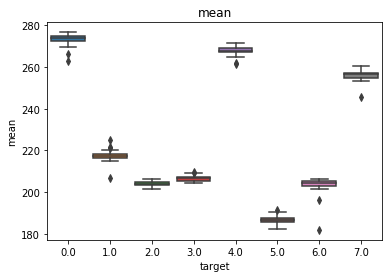

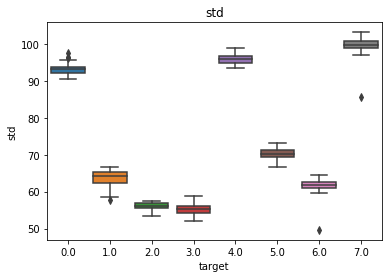

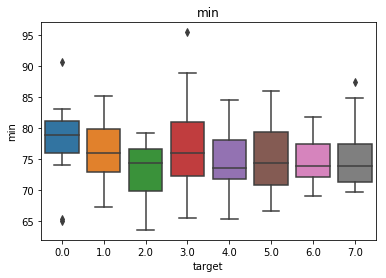

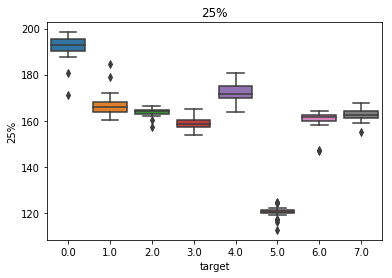

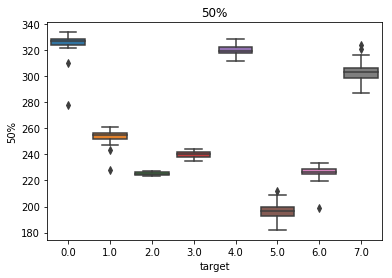

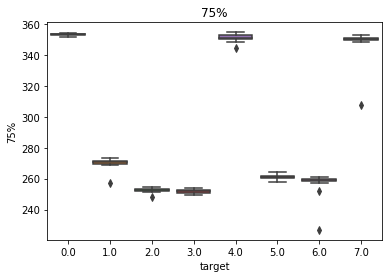

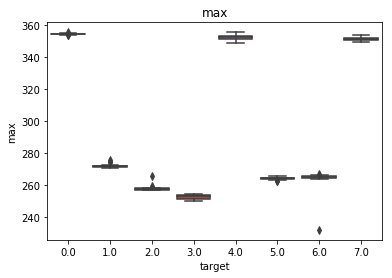

In [4]:
j = 1

for feature in list(test_data.columns) :
    
    plt.figure(j)
    
    sns.boxplot(x = 'target', y = feature, data = train_data )

    plt.title(feature)
    
    j += 1
    

## 2. 建立 XGBoost 模型，並以 grid search 找出最佳模型。

In [5]:
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(pd.concat([train_data.drop(['target'], axis = 1), test_data]))

train_X = pd.DataFrame(scaler.transform(train_data.drop(['target'], axis = 1)), columns = train_data.columns[:-1])

train_Y = train_data['target']

test_X = pd.DataFrame(scaler.transform(test_data), columns = test_data.columns)

In [6]:
def Model(train_X, train_Y, test_X) :
    
    
    gridsearch_params = [
        (maxdepth, subsample, colsample)
        for maxdepth in [i for i in range(2,12,2)]
        for subsample in [i/10 for i in range(7,11)]
        for colsample in [i/10 for i in range(7,11)]
    ]
    
    best_score = 0
    
    '''
    w = Y_train.value_counts().min() / Y_train.value_counts()
    
    w_dict = dict(zip(w.index, w))
    
    train = xgb.DMatrix(X_train, Y_train, weight = np.array(Y_train.apply(lambda x: w_dict[x]))) 
    
    '''
    
    train = xgb.DMatrix(train_X, train_Y)
    
    k = 1
    
    for maxdepth, subsample, colsample in gridsearch_params :
    
        init_params = {

        'n_estimators':1000,
        'eta': 0.000001,
        'max_depth': maxdepth,
        'subsample': subsample,
        'colsample_bytree': colsample,
        'objective': 'multi:softprob',
        'silent': 1,
        'num_class' : 8
            
        }
        
        
        cv_output = xgb.cv(init_params, train, num_boost_round = init_params['n_estimators'], early_stopping_rounds = 10, verbose_eval=False, show_stdv=False
                 , nfold = 10)
            
        local_best = 1 - cv_output.iloc[(len(cv_output) - 1), 2]
        
        print()
        
        if k % 16 == 0 :
        
            print('%d/%d combinations had done !'%(k, len(gridsearch_params)))
        
        k += 1
        
        if local_best > best_score :
            
            best_score = local_best
            
            best_params = [maxdepth, subsample, colsample]
            
            best_iterations = len(cv_output)
            
            
    train_params = {

        'n_estimators':best_iterations,
        'eta': 0.000001,
        'max_depth': best_params[0],
        'subsample': best_params[1],
        'colsample_bytree': best_params[2],
        'objective': 'multi:softprob',
        'silent': 1,
        'num_class' : 8
        
    }
    
    model = xgb.train(train_params, train, num_boost_round = best_iterations)
    
    feature_importance = pd.DataFrame({'features':list(model.get_fscore().keys()), 'importance':list(model.get_fscore().values())})
    
    feature_importance = feature_importance.sort_values(by = 'importance')
    
    test = xgb.DMatrix(test_X)
    
    prediction = model.predict(test)
    
    return best_score, best_params, best_iterations, np.argmax(prediction, axis = 1), feature_importance

In [7]:
best_score, best_params, best_iterations, prediction, feature_importance = Model(train_X, train_Y, test_X)

16/80 combinations had done !
32/80 combinations had done !
48/80 combinations had done !
64/80 combinations had done !
80/80 combinations had done !


#### 10 fold cv 下，valid set 準確度高達 99.1 %

In [8]:
best_score, best_params, best_iterations

(0.9913044, [4, 1.0, 0.8], 5)

<BarContainer object of 8 artists>

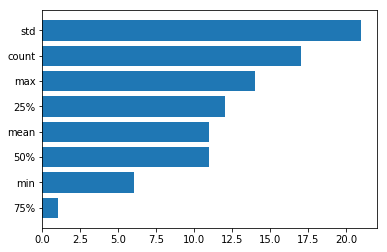

In [9]:
plt.barh(feature_importance['features'], feature_importance['importance'])

In [10]:
submit = pd.read_csv('03_test.csv')
submit = submit.loc[:35]
submit['分類結果'] = [pred_2_type[x] for x in list(prediction) ]

In [11]:
submit.to_csv('./submit/03_Test.csv', index = False, encoding='utf_8_sig' )